### Import required libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Utility functions for camera calibration and preliminary image processing

In [2]:
def calc_calibration_matrix():
    # Calculate camera calibration by loading chessboard images from the camera_cal folder
    images = glob.glob('camera_cal/calibration*.jpg')
    
    cal_mtx, dist = None, None

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    nx = 9
    ny = 6

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
    if objpoints != [] and imgpoints != []:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, cal_mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
    return cal_mtx, dist

In [3]:
def color_gradient_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = (hls[:,:,2]).astype(np.uint8)  # if img is read by mpimg and is .png then * 255 for s-channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Color Thresholding with s-channel for yellow
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Color thresholding with RGB for white
    low_threshold = np.array([200, 200, 200])
    high_threshold = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, low_threshold, high_threshold)
    white_mask[white_mask!=0] = 1

    # Gradient Thresholding
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    mag_sobel = np.sqrt(sobelx**2)
    scale_factor = np.max(mag_sobel) / 255
    scaled_sobel = (mag_sobel / scale_factor).astype(np.uint8)
    thresh_min = 50
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Combine color and gradient to create one binary output
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (white_mask == 1)] = 1
    
    return combined_binary

In [4]:
def perspective_transform(img):
    img_width = img.shape[1]
    img_height = img.shape[0]
    # Compute src points for transform  --> taken w.r.t. straight_lines1.jpg
    s1 = [img_width//2 - 75, 450]  # Trapezoid edge is at 450
    s2 = [img_width//2 + 75, 450]
    s3 = [-100, img_height]
    s4 = [img_width + 100, img_height]
    src = np.float32([s1, s2, s3, s4])
    # Compute dst points for transform
    # Lines in the transformed image must be parallel
    dst = np.float32([[100, 0], [img_width-100, 0], [100, img_height], [img_width-100, img_height]])
    M = cv2.getPerspectiveTransform(src, dst)  # get Perspective transform matrix
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_width, img_height))
    
    return warped, M_inv

### Define Line Class to store necessary attributes for left and right lanes

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [6]:
# Instantiate line objects to represent left lane and right lane
left_lane = Line()
right_lane = Line()

In [7]:
# Find histogram peaks --> used in sliding window to detect base of lane lines
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    imshape = img.shape
    bottom_half = img[470:, :]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

### Find lane pixels using sliding window or search around fit from previous frame (search from prior)

In [8]:
def sliding_window(binary_warped):
    """
    Find lane line pixels using sliding window approach
    """
    # Calculate histogram of the binary warped image (after thresholding and
    # perspective transform)
    histogram = hist(binary_warped)
    
    # For visualizing the output --> stack the binary images to form 3-channel
    warped = binary_warped * 255  # Convert binary_warped to scale 0-255
    out_img = np.dstack((warped, warped, warped))
    
    # Find starting point of lane lines using histogram of the bottom half of the image
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])  # left lane start point
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint  # right lane start point
    
    # Set hyperparameters for Sliding Window
    nwindows = 9  # Choose the number of sliding windows
    margin = 100  # Set the width of the windows +/- margin
    minpix = 50   # Set minimum number of pixels found to recenter window
    window_height = np.int(binary_warped.shape[0]//nwindows)# Set height of windows based on nwindows & image shape
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()  # nonzero() returns a tuple of x and y coords where binary_warped!=0
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image (out_img)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify non-zero pixels within the current window
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
                        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
                        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Update next window center to mean(good_lane_inds) if good_left_inds and good_right_inds > minpix
        if len(good_left_inds) > minpix:
            leftx_current = sum(nonzerox[good_left_inds])//len(nonzerox[good_left_inds])
        if len(good_right_inds) > minpix:
            rightx_current = sum(nonzerox[good_right_inds])//len(nonzerox[good_right_inds])
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract the left lane and right lane pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit second order polynomials to nonzero pixels for left and right lanes separately
    left_lane.current_fit = np.polyfit(lefty, leftx, 2)
    right_lane.current_fit = np.polyfit(righty, rightx, 2)
    
    left_lane.detected, right_lane.detected = True, True
    left_lane.allx, left_lane.ally = leftx, lefty
    right_lane.allx, right_lane.ally = rightx, righty
    
    ## Visualization of fitted lines ##
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
    right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty,rightx] = [0, 0, 255]
    
    return out_img

In [9]:
def search_from_prior(binary_warped):
    """
    Search around poly takes in fitted params left_fit and right_fit and searches for 
    nonzero values +/- margin from the points generated from the given params
    """
    # HYPERPARAMETER
    margin = 100  # Choose the width of the margin around the previous polynomial to search

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ((nonzerox >= left_fitx - margin) & (nonzerox < left_fitx + margin))
    right_lane_inds = ((nonzerox >= right_fitx - margin) & (nonzerox < right_fitx + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials only if sufficient pixels are etected, else use previous (averaged) fit
    if len(left_lane_inds) >= 10 and len(right_lane_inds) >= 10:
        left_lane.current_fit = np.polyfit(lefty, leftx, 2)
        right_lane.current_fit = np.polyfit(righty, rightx, 2)
        
        left_lane.allx, left_lane.ally = leftx, lefty
        right_lane.allx, right_lane.ally = rightx, righty
    else:
        left_lane.detected = False
        right_lane.detected = False
        
    ## Visualization for debugging ##
    # Create an image to draw on and an image to show the selection window
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
#     left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
#     right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]
    
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty,rightx] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     # End visualization steps ##
    
    return out_img

In [10]:
def find_lane_pixels(binary_warped):
    """ 
    Find lane line pixels using sliding window approach or search from prior
    """
    if right_lane.detected == False or left_lane.detected == False:
        out_img = sliding_window(binary_warped)
    else:
        out_img = search_from_prior(binary_warped)
#     out_img = sliding_window(binary_warped)
    return out_img

### Measure radius of curvature, and lane offset from vehicle centre

In [11]:
def measure_curvature(out_img, ym_per_pix=1, xm_per_pix=1):
    """
    Measure radius of curvature of the lane in meters
    xm_per_pix and ym_per_pix are used to convert to meter space from pixel space
    """
    # Retrieve non-zero pixels 
    leftx, lefty = left_lane.allx, left_lane.ally
    rightx, righty = right_lane.allx, right_lane.ally
    
    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)  # list of params for left lane
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)  # list of params for right lane
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    left_lane.radius_of_curvature = ((1+(2*left_fit[0]*y_eval + left_fit[1])**2)**1.5)/abs(2*left_fit[0])
    right_lane.radius_of_curvature = ((1+(2*right_fit[0]*y_eval + right_fit[1])**2)**1.5)/abs(2*right_fit[0])
    
    avg_curvature = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2.0
    return avg_curvature

In [12]:
def measure_dist_from_center(img, xm_per_pix=1):
    img_centre = img.shape[1]/2 
    
    # We are evaluating lane centre at the bottom of the image
    y_eval = img.shape[0]  
    # We must calculate the x-coordinate of the fitted left and right lanes at the bottom of the image
    leftx = left_lane.current_fit[0]*y_eval**2 + left_lane.current_fit[1]*y_eval + left_lane.current_fit[2]
    rightx = right_lane.current_fit[0]*y_eval**2 + right_lane.current_fit[1]*y_eval + right_lane.current_fit[2]
    
    lane_centre = (leftx + rightx)/2.0
    offset = (lane_centre - img_centre)*xm_per_pix
    
    return offset
    

### Define complete pipeline for advanced lane detection

In [13]:
def pipeline(img):
    # Calibrate camera to calculate calibration matrix co-eff
    cal_mtx, dist = calc_calibration_matrix()
    undistort = cv2.undistort(img, cal_mtx, None, cal_mtx)
    binary_img = color_gradient_threshold(undistort)
    binary_warped, Minv = perspective_transform(binary_img)
    out_img = find_lane_pixels(binary_warped)
    
    '''
    Let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!),
    and we'll say roughly 700 relevant pixels in the x-dimension (from 200 pixels on the left to 900 on the right, or 700). 
    Therefore, to convert from pixels to real-world meter measurements, we can use:
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    avg_curvature = measure_curvature(out_img, ym_per_pix, xm_per_pix)
    avg_dist = measure_dist_from_center(binary_warped, xm_per_pix)

    
    #### Visualization ####    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(out_img).astype(np.uint8)
    # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
    right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
    
    # Write radius of curvature and dist from center on t the image
    if avg_curvature > 2500:
        radius_str = "Road is Straight"
    else:
        radius_str = 'Radius of Curvature: {:.3f}m'.format(avg_curvature)
    dist_str = "Distance from center: {:.3f}m".format(avg_dist)
    result = cv2.putText(result, radius_str, (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    # Write distance from vehicle centre
    result = cv2.putText(result, dist_str, (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA) 
    return result

### Test on images

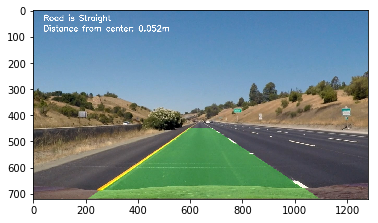

In [14]:
image = mpimg.imread("test_images/straight_lines1.jpg")
out_img = pipeline(image)
plt.imshow(out_img)
plt.show()

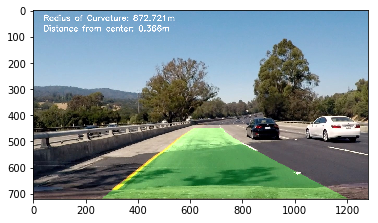

In [15]:
image = mpimg.imread("test_images/test4.jpg")
out_img = pipeline(image)
plt.imshow(out_img)
plt.savefig("./output_images/out_image.png")

### Test on video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile("project_output.mp4", audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  1%|          | 14/1261 [00:53<1:19:41,  3.83s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_output.mp4"))